<a href="https://colab.research.google.com/github/NirachaNick/ClassifyingSaleabilityofLime-CNN/blob/main/CNN_saleability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN model for predicting saleablity

## 1. Model preparation

In [ ]:
from keras.preprocessing.image import img_to_array

class ImageToArrayPreprocessor:
    def __init__(self, dataFormat=None):
# store the image data format
        self.dataFormat = dataFormat

    def preprocess(self, image):
# apply the Keras utility function that correctly rearranges
# the dimensions of the image
        return img_to_array(image, data_format=self.dataFormat)

In [ ]:
import numpy as np
import cv2
import os

class SimpleDatasetLoader:
    def __init__(self, preprocessors=None):
# store the image preprocessor
        self.preprocessors = preprocessors

# if the preprocessors are None, initialize them as an
# empty list
        if self.preprocessors is None:
            self.preprocessors = []

    def load(self, imagePaths, verbose=-1):
# initialize the list of features and labels
        data = []
        labels = []

# loop over the input images
        for (i, imagePath) in enumerate(imagePaths):
# load the image and extract the class label assuming
# that our path has the following format:
# /path/to/dataset/{class}/{image}.jpg
            image = cv2.imread(imagePath)
            label = imagePath.split(os.path.sep)[-2]
# check to see if our preprocessors are not None
            if self.preprocessors is not None:

                for p in self.preprocessors:
                    image = p.preprocess(image)

# treat our processed image as a "feature vector"
 # by updating the data list followed by the labels

            data.append(image)
            labels.append(label)

# show an update every ‘verbose‘ images
            if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
                print("[INFO] processed {}/{}".format(i + 1,len(imagePaths)))

# return a tuple of the data and labels
        return (np.array(data), np.array(labels))

In [ ]:
import imutils
import cv2

class AspectAwarePreprocessor:
    def __init__(self, width, height, inter=cv2.INTER_AREA):
# store the target image width, height, and interpolation
# method used when resizing
        self.width = width
        self.height = height
        self.inter = inter

    def preprocess(self, image):
# grab the dimensions of the image and then initialize
# the deltas to use when cropping
        (h, w) = image.shape[:2]
        dW = 0
        dH = 0

# if the width is smaller than the height, then resize
# along the width (i.e., the smaller dimension) and then
# update the deltas to crop the height to the desired
# dimension
        if w < h:
            image = imutils.resize(image, width=self.width,
                inter=self.inter)
            dH = int((image.shape[0] - self.height) / 2.0)

# otherwise, the height is smaller than the width so
# resize along the height and then update the deltas
# to crop along the width
        else:
            image = imutils.resize(image, height=self.height,
                inter=self.inter)
            dW = int((image.shape[1] - self.width) / 2.0)

# now that our images have been resized, we need to
# re-grab the width and height, followed by performing
# the crop
        (h, w) = image.shape[:2]
        image = image[dH:h - dH, dW:w - dW]

# finally, resize the image to the provided spatial
# dimensions to ensure our output image is always a fixed
# size
        return cv2.resize(image, (self.width, self.height),
            interpolation=self.inter)

In [ ]:
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers.core import Flatten
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Rescaling
import numpy as np
import argparse
import cv2
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

## 2. Parameters setting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Parameters setting secction --------------------------------------------------------------------------------------

#Image File Directories

# This is the location of the entire dataset
image_path_train = '/content/drive/MyDrive/regular_angle_imgs'

#Weight Save Directory
Weight_Save_Path = '/content/drive/MyDrive/Weight_save_directory/Round4/CNN_saleability_CDC_08.h5'

#Model Train Parameters (the values are obtained from the DOE)
BATCH_SIZE = 111
ep = 480
Learning_Rate = 0.01875
Decay_Rate = 0.001875
Momentum_Rate = 0.846339


## 3. Model training

In [ ]:
#Model Training Section ------------------------------------------------------------------------------------------

imagePaths = list(paths.list_images(image_path_train))

# initialize the image preprocessors
sp = AspectAwarePreprocessor(128,128)
iap = ImageToArrayPreprocessor()

# load the dataset from disk then scale the raw pixel intensities
# to the range [0, 1]
sdl = SimpleDatasetLoader(preprocessors=[sp, iap])
(data, labels) = sdl.load(imagePaths, verbose=500)
data = data.astype("float") / 255.0

# set aside 10% of train and test data for evaluation
X_train, testX, Y_train, testY = train_test_split(data, labels,
    test_size=0.1, random_state = 32)

# Use the same function above for the validation set
trainX, valX, trainY, valY = train_test_split(X_train, Y_train,
    test_size=1/9, random_state= 32) # 1/9 x 0.9 = 0.1

# convert the labels from integers to vectors
trainY = LabelBinarizer().fit_transform(trainY)
valY = LabelBinarizer().fit_transform(valY)
testY = LabelBinarizer().fit_transform(testY)

# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")


classes = 3
batch = BATCH_SIZE
chanDim = 1

[INFO] processed 500/2120
[INFO] processed 1000/2120
[INFO] processed 1500/2120
[INFO] processed 2000/2120


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 activation_36 (Activation)  (None, 128, 128, 64)      0         
                                                                 
 conv2d_25 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 activation_37 (Activation)  (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 64, 64, 128)       73856     
                                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/480
16/16 [==============================] - ETA: 0s - loss: 1.0681 - accuracy: 0.4045
Epoch 1: val_loss improved from inf to 1.06696, saving model to /content/drive/MyDrive/Weight_save_directory/Round5/CNN_saleability_cf_5.h5
16/16 [==============================] - 7s 409ms/step - loss: 1.0681 - accuracy: 0.4045 - val_loss: 1.0670 - val_accuracy: 0.3726
Epoch 2/480
16/16 [==============================] - ETA: 0s - loss: 1.0433 - accuracy: 0.4399
Epoch 2: val_loss improved from 1.06696 to 1.03339, saving model to /content/drive/MyDrive/Weight_save_directory/Round5/CNN_saleability_cf_5.h5
16/16 [==============================] - 6s 411ms/step - loss: 1.0433 - accuracy: 0.4399 - val_loss: 1.0334 - val_accuracy: 0.4575
Epoch 3/480
16/16 [==============================] - ETA: 0s - loss: 0.9643 - accuracy: 0.5613
Epoch 3: val_loss improved from 1.03339 to 0.90026, saving model to /content/drive/MyDrive/Weight_save_directory/Round5/CNN_saleability_cf_5.h5
16/16 [==================

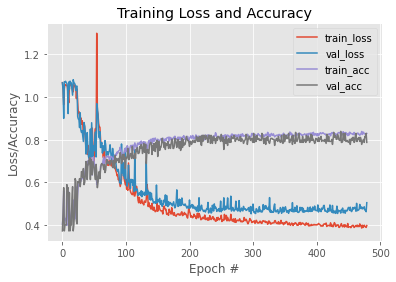

In [ ]:
# define model
model = Sequential()
model.add(Conv2D(64,(3,3),padding="same", input_shape=(128,128, 3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128,(3,3),padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256,(3,3),padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation("relu"))
#model.add(Conv2D(256,(3,3),padding="same"))
#model.add(Activation('relu'))
#model.add(Conv2D(256, (3, 3), padding="same"))
#model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Conv2D(512,(3,3),padding="same"))
#model.add(Activation("relu"))
#model.add(Conv2D(512, (3, 3), padding="same"))
#model.add(Activation("relu"))
#model.add(Conv2D(512,(3,3),padding="same"))
#model.add(Activation('relu'))
#model.add(Conv2D(512, (3, 3), padding="same"))
#model.add(Activation("relu"))
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
#model.add(Dense(4096))
#model.add(Activation("relu"))
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dense(128))
model.add(Activation("relu"))

model.add(Dense(classes))
model.add(Activation("softmax"))

print(model.summary())

# train the model using SGD
print("[INFO] training network...")
sgd = keras.optimizers.SGD(lr=Learning_Rate, decay=Decay_Rate, momentum=Momentum_Rate)
model.compile(loss="categorical_crossentropy", optimizer=sgd,
    metrics=["accuracy"])

#Model check point
checkpoint = ModelCheckpoint(Weight_Save_Path, monitor="val_loss",
            save_best_only=True, verbose=1)
callbacks = [checkpoint]

H = model.fit(aug.flow(trainX, trainY, batch_size=batch), validation_data = (valX, valY), callbacks=callbacks,
    epochs=ep, verbose=1)


# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, ep), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, ep), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, ep), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, ep), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


## 4. Model testing

In [ ]:
#Model Testing Section------------------------------------------------------------------------------

model = load_model(Weight_Save_Path)
batch=BATCH_SIZE

# define label for each class
labelNames = [ "Sold","Maybe", "Notbuy"]


print("[INFO] evaluation testing for training data ...")
# run prediction for training data
predictions = model.predict(trainX, batch_size=batch)
# print(predictions) # for debugging purpose
# print(trainY) # for debugging purpose
# dsiplay the performance

print(classification_report(trainY.argmax(axis=1),
    predictions.argmax(axis=1),target_names=labelNames))


print("[INFO] evaluation testing for validating data ...")
# run prediction for training data
predictions = model.predict(valX, batch_size=batch)
# dsiplay the performance
print(classification_report(valY.argmax(axis=1),
    predictions.argmax(axis=1),target_names=labelNames))


print("[INFO] evaluation testing for test data ...")
# run prediction for testing data
predictions = model.predict(testX, batch_size=batch)
# dsiplay the performance
print(classification_report(testY.argmax(axis=1),
    predictions.argmax(axis=1),target_names=labelNames))

[INFO] evaluation testing for training data ...
              precision    recall  f1-score   support

        Sold       0.88      0.90      0.89       653
       Maybe       0.65      0.59      0.62       346
      Notbuy       0.89      0.91      0.90       697

    accuracy                           0.84      1696
   macro avg       0.81      0.80      0.80      1696
weighted avg       0.84      0.84      0.84      1696

[INFO] evaluation testing for validating data ...
              precision    recall  f1-score   support

        Sold       0.89      0.91      0.90        79
       Maybe       0.68      0.62      0.65        48
      Notbuy       0.86      0.88      0.87        85

    accuracy                           0.83       212
   macro avg       0.81      0.81      0.81       212
weighted avg       0.83      0.83      0.83       212

[INFO] evaluation testing for test data ...
              precision    recall  f1-score   support

        Sold       0.91      0.94      0.